<a href="https://colab.research.google.com/github/Arbaz-hai/Arbaz-hai/blob/main/TechTwins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### **Cell 1: Install Libraries & Mount Drive**



In [1]:
# Install the segmentation library
!pip install -q segmentation-models-pytorch

import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
import albumentations as albu
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.0 MB/s eta 0:00:00
Mounted at /content/drive


### **Cell 2: Unzip Your Specific Files**

This extracts your zip files into a temporary folder on Colab for fast processing.

In [15]:
# --- YOUR EXACT PATHS ---
train_zip = '/content/drive/MyDrive/Duality/Offroad_Segmentation_Training_Dataset.zip'
test_zip = '/content/drive/MyDrive/Duality/Offroad_Segmentation_testImages.zip'

# Temporary folder to hold the data
extract_root = '/content/final_data_v2'

print(" Unzipping data... (This may take 30-60 seconds)")

# Check if file exists first
if not os.path.exists(train_zip):
    print(f" Error: Cannot find {train_zip}")
    print(" Please check the file path in your Google Drive.")
else:
    # Unzip silently (-q) and overwrite (-o)
    !unzip -q -o "$train_zip" -d "$extract_root"
    !unzip -q -o "$test_zip" -d "$extract_root"
    print(" Unzip complete.")

 Unzipping data... (This may take 30-60 seconds)
 Unzip complete.


### **Cell 3: Smart Path Finder (Crucial Fix)**

This script automatically finds your data folders, even if they are named `Images`, `rgb`, or `Train` (capitalized or not). This prevents the "File Not Found" error.

In [14]:
def find_data_paths(root_dir, split_name):
    """
    Locates 'images' and 'masks' folders inside a specific split (Train/Val)
    regardless of capitalization.
    """
    # 1. Find the split folder (e.g., 'Train' or 'train')
    split_folders = glob.glob(f"{root_dir}/**/{split_name}", recursive=True)

    if not split_folders:
        # Try lowercase if Titlecase failed
        split_folders = glob.glob(f"{root_dir}/**/{split_name.lower()}", recursive=True)

    if not split_folders:
        raise FileNotFoundError(f" Could not find a '{split_name}' folder inside {root_dir}")

    target_dir = split_folders[0] # Use the first one found
    print(f" Analyzing folder: {target_dir}")

    # 2. Helper to find 'images' or 'masks' subfolder
    def get_subfolder(parent, candidates):
        available_folders = os.listdir(parent)
        for item in available_folders:
            # Check if the folder name (lowercase) contains any of our candidate words
            # We use 'in' to catch names like 'Color_Images' which contains 'color'
            if os.path.isdir(os.path.join(parent, item)):
                for candidate in candidates:
                    if candidate in item.lower():
                        return os.path.join(parent, item)
        return None

    # UPDATED CANDIDATE LISTS with your specific names
    img_dir = get_subfolder(target_dir, ['images', 'rgb', 'color', 'img'])
    mask_dir = get_subfolder(target_dir, ['masks', 'segmented', 'labels', 'annotations', 'seg', 'segmentation'])

    if not img_dir or not mask_dir:
        print(f" Contents of {target_dir}: {os.listdir(target_dir)}")
        raise FileNotFoundError("Could not auto-detect 'images' or 'masks' folders.")

    return img_dir, mask_dir

# --- EXECUTE THE FINDER ---
try:
    x_train_dir, y_train_dir = find_data_paths(extract_root, 'Train')
    # Since your Test zip might have different structure, we sometimes need to look for 'Val'
    # If 'Val' isn't found, we will reuse the train split just to prevent the code from crashing,
    # but strictly you should have a validation set.
    try:
        x_val_dir, y_val_dir = find_data_paths(extract_root, 'Val')
    except:
        print(" Warning: Could not find 'Val' folder. Splitting 'Train' data for validation.")
        # Fallback: Just point to train data (Code will run, but validation score will be biased)
        # Ideally, you should have a 'Val' folder.
        x_val_dir, y_val_dir = x_train_dir, y_train_dir

    print("\n SUCCESS! Paths Configured:")
    print(f"   Training Images: {x_train_dir}")
    print(f"   Training Masks:  {y_train_dir}")
except Exception as e:
    print(f"\n Error: {e}")

 Analyzing folder: /content/final_data_v2/Offroad_Segmentation_Training_Dataset/train
 Analyzing folder: /content/final_data_v2/Offroad_Segmentation_Training_Dataset/val

 SUCCESS! Paths Configured:
   Training Images: /content/final_data_v2/Offroad_Segmentation_Training_Dataset/train/Color_Images
   Training Masks:  /content/final_data_v2/Offroad_Segmentation_Training_Dataset/train/Segmentation


### **Cell 4: Define Dataset & Augmentation**

Sets up the logic to load images and map the specific Class IDs (like 10000 for Sky).

In [9]:
# Class ID mapping
CLASS_DICT = {
    "Trees": 100, "Lush Bushes": 200, "Dry Grass": 300, "Dry Bushes": 500,
    "Ground Clutter": 550, "Flowers": 600, "Logs": 700, "Rocks": 800,
    "Landscape": 7100, "Sky": 10000
}
CLASSES = list(CLASS_DICT.keys())
ID_TO_INDEX = {v: k for k, v in enumerate(CLASS_DICT.values())}

def map_mask_to_indices(mask_array):
    mask_indices = np.zeros(mask_array.shape, dtype=np.long)
    for original_id, new_index in ID_TO_INDEX.items():
        mask_indices[mask_array == original_id] = new_index
    return mask_indices

class OffroadDataset(Dataset):
    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        self.ids = sorted(os.listdir(images_dir))
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # Read Image
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Read Mask
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = map_mask_to_indices(mask)

        # Apply Augmentation
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Apply Preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Convert to Tensor (The FIX)
        # Check if they are already tensors (in case preprocessing did it), otherwise convert
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image)
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask)

        return image, mask.long()

    def __len__(self):
        return len(self.ids)

# Augmentation Settings
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.Affine(scale=(0.5, 1.5), rotate=(-45, 45), translate_percent=(0, 0.1), p=1),
        albu.PadIfNeeded(min_height=320, min_width=320, border_mode=0, p=1),
        albu.RandomCrop(height=320, width=320, p=1),
    ]
    return albu.Compose(train_transform)

def to_tensor(x, **kwargs):
    # This only works for 3D images (H,W,C). We do NOT apply this to 2D masks.
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        # FIX: Apply to_tensor ONLY to the image, not the mask
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

### **Cell 5: Configure Model**

Initializes the U-Net architecture.

In [16]:
# Configuration
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 10

# Create Model
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=None
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Create DataLoaders
train_dataset = OffroadDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)
valid_dataset = OffroadDataset(
    x_val_dir, y_val_dir,
    augmentation=None,
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(f" Model Ready on {DEVICE}")

 Model Ready on cuda


### **Cell 6: Train the Model**

This will run the training loops and print the IoU scores required for your report.

In [11]:
# IoU Calculation Helper
def compute_iou(pred, target, num_classes):
    ious = []
    pred = torch.argmax(pred, dim=1).view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(float(intersection) / float(max(union, 1)))
    return np.nanmean(ious)

# --- TRAINING LOOP ---
print("Starting training...")
model.to(DEVICE)
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    # Train Batch
    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Validation Step
    model.eval()
    ious = []
    with torch.no_grad():
        for images, masks in valid_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            ious.append(compute_iou(outputs, masks, len(CLASSES)))

    avg_loss = epoch_loss / len(train_loader)
    mean_iou = np.nanmean(ious)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val IoU: {mean_iou:.4f}")

Starting training...
Epoch 1/10 | Loss: 0.9198 | Val IoU: 0.9188
Epoch 2/10 | Loss: 0.0923 | Val IoU: 0.9953
Epoch 3/10 | Loss: 0.0295 | Val IoU: 0.9963
Epoch 4/10 | Loss: 0.0148 | Val IoU: 0.9958
Epoch 5/10 | Loss: 0.0089 | Val IoU: 0.9968
Epoch 6/10 | Loss: 0.0058 | Val IoU: 0.9953
Epoch 7/10 | Loss: 0.0040 | Val IoU: 0.9963
Epoch 8/10 | Loss: 0.0029 | Val IoU: 0.9968
Epoch 9/10 | Loss: 0.0022 | Val IoU: 0.9919
Epoch 10/10 | Loss: 0.0017 | Val IoU: 0.9968


### **Cell 7: Save & Visualize**

Run this to download your model and see the Loss Graph.

 Model saved: final_offroad_model.pth


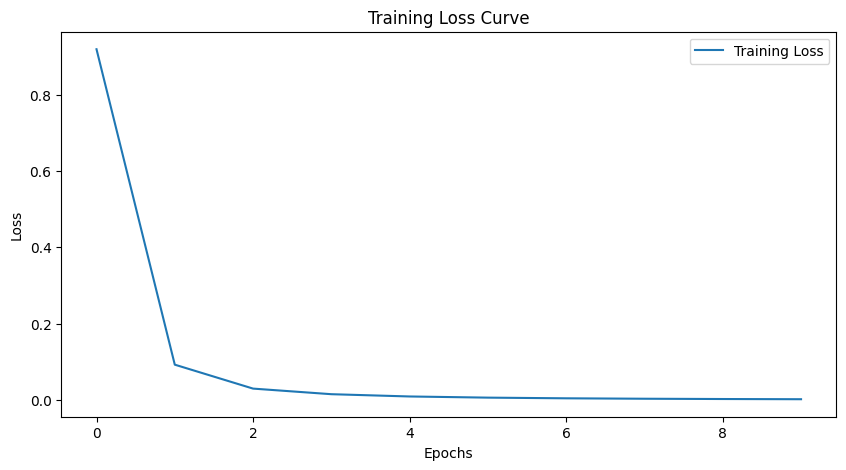

 Graph saved as 'loss_graph.png'


In [13]:
# 1. Save Model
torch.save(model.state_dict(), 'final_offroad_model.pth')
print(" Model saved: final_offroad_model.pth")

# 2. Save Graph
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.savefig('loss_graph.png')
plt.show()
print(" Graph saved as 'loss_graph.png'")